In [1]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision
import requests
from pathlib import Path
import os
import random
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision import models
from tqdm import tqdm
from timeit import timeit as timer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import LinearLR, SequentialLR
from typing import Tuple, Dict, List
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from time import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [92]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index) :
        img_path = self.image_paths[index]
        label = self.labels[index]

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

In [93]:
class EarlyStopping:
    def __init__(self, patience = 5, min_delta=0, restore_best_weights = True):
        self.patience = patience
        self.min_delta = min_delta  
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model = model.state_dict()
        else:
            self.counter +=1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_model is not None:
                    model.load_state_dict(self.best_model)

In [94]:
data_path = Path("PKG_C_NMC")
train_dir = data_path / "C-NMC_training_data"
test_prelim_dir = data_path / "test_prelim"
test_final_dir = data_path / "test_final"
train_dir, test_final_dir, test_prelim_dir

(WindowsPath('PKG_C_NMC/C-NMC_training_data'),
 WindowsPath('PKG_C_NMC/test_final'),
 WindowsPath('PKG_C_NMC/test_prelim'))

In [95]:
def load_data(data_dir):
    images_paths = []
    labels = []
    subject_ids = []

    for fold_name in os.listdir(data_dir):
        fold_path = os.path.join(data_dir, fold_name)
        if not os.path.isdir(fold_path):
            continue


        # Load cancer cells - 'all'
        all_folder = os.path.join(fold_path, "all")
        if os.path.exists(all_folder):
            for file_name in os.listdir(all_folder):
                if file_name.endswith(('.bmp')):
                    images_paths.append(os.path.join(all_folder, file_name))
                    labels.append(1)

                    parts = file_name.split('_')
                    subject_id = parts[1] if len(parts) > 1 else "unknown"
                    subject_ids.append(f"cancer_{subject_id}")

        # Load normal cells - 'hem'
        hem_folder = os.path.join(fold_path, "hem")
        if os.path.exists(hem_folder):
            for file_name in os.listdir(hem_folder):
                if file_name.endswith(('.bmp')):
                    images_paths.append(os.path.join(hem_folder, file_name))
                    labels.append(0)

                    parts = file_name.split('_')
                    subject_id = f"{parts[1]}_{parts[2]}" if len(parts) >= 3 else "unknown"
                    subject_ids.append(f"normal_{subject_id}")

    return images_paths, labels, subject_ids

In [96]:
image_paths, labels, subject_ids = load_data(train_dir)

In [97]:
len(image_paths), len(labels), len(subject_ids), subject_ids.count('cancer_1')

(10661, 10661, 10661, 19)

In [98]:
len(list(set(subject_ids)))

892

In [99]:
def split_data(image_paths, labels, subject_ids, test_size=0.2):
    unique_subjects = list(set(subject_ids))

    train_subjects, val_subjects = train_test_split(unique_subjects, 
                                                    test_size=test_size, 
                                                    random_state=42, 
                                                    stratify= [s.split('_')[0] for s in unique_subjects])

    train_paths, train_labels = [], []
    val_paths, val_labels = [], []

    for path, label, subject in zip(image_paths, labels, subject_ids):
        if subject in train_subjects:
            train_paths.append(path)
            train_labels.append(label)
        else:
            val_paths.append(path)
            val_labels.append(label)

    return train_paths, train_labels, val_paths, val_labels

In [100]:
train_paths, train_labels, val_paths, val_labels = split_data(image_paths=image_paths, 
                                                                labels=labels,
                                                                subject_ids=subject_ids)

In [101]:
def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(degrees=5),
        transforms.ColorJitter(brightness=0.05, contrast=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

train_transform, val_transform = get_transforms()

In [102]:
train_dataset = CustomDataset(image_paths=train_paths, labels=train_labels, transform=train_transform)
val_dataset = CustomDataset(image_paths=val_paths, labels=val_labels, transform=val_transform)

batch_size=32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [103]:
class LeukemiaCNN(nn.Module):
    def __init__(self, num_classes=2, pretrained=True) :
        super().__init__()

        # self.model = models.resnet34(pretrained=pretrained)
        self.model = models.densenet121(pretrained=pretrained)

        # num_features = self.model.fc.in_features
        # self.model.fc = nn.Sequential(
        #     nn.Dropout(0.5),
        #     nn.Linear(in_features=num_features, out_features=128),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(128, num_classes)
        # )

        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=num_features, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, X):
        return self.model(X)

In [104]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [105]:
def train_step(model:nn.Module, loss_fn:nn.Module, optimizer:torch.optim.Optimizer, dataloader:torch.utils.data.DataLoader, device=device):

    model.train()
    train_loss = 0.0
    train_acc = 0
    train_recall = 0
    all_preds, all_labels = [], []
    all_probs = []

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_logits = model(X)
        
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_probs = F.softmax(y_logits, dim=1)
        y_preds = torch.argmax(y_logits, dim=1)
        all_probs.extend(y_probs.detach().cpu().numpy())
        all_preds.extend(y_preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())
        train_acc += accuracy_fn(y_true=y, y_pred=y_preds)
        train_recall += recall_score(y_true=y, y_pred=y_preds, average='weighted', zero_division=0)


    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    train_recall /= len(dataloader)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    all_probs_positive = [prob[1] for prob in all_probs]
    train_roc_curve = roc_auc_score(all_labels, all_probs_positive)

    return train_loss, train_f1, train_roc_curve, train_acc, train_recall


In [106]:
def val_step(model:nn.Module,
            loss_fn:nn.Module,
            dataloader:torch.utils.data.DataLoader,
            device=device):

    model.eval()
    val_loss = 0.0
    val_acc, val_recall = 0, 0
    all_preds, all_labels = [], []
    all_probs = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            val_logits = model(X)
            loss = loss_fn(val_logits, y)
            val_loss += loss.item()

            val_probs = F.softmax(val_logits, dim=1)
            val_preds = torch.argmax(val_logits, dim=1)
            all_probs.extend(val_probs.detach().cpu().numpy())
            all_preds.extend(val_preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())
            val_acc += accuracy_fn(y_true=y, y_pred=val_preds)
            val_recall += recall_score(y_true=y, y_pred=val_preds, average='weighted', zero_division=0)

        val_loss /= len(dataloader)
        val_acc /= len(dataloader)
        val_recall /= len(dataloader)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        all_probs_positive = [prob[1] for prob in all_probs]
        val_roc_curve = roc_auc_score(all_labels, all_probs_positive)

    return val_loss, val_f1, val_roc_curve, val_acc, val_recall


In [107]:
def train_model(model:nn.Module, 
                train_dataloader:torch.utils.data.DataLoader,
                val_dataloader:torch.utils.data.DataLoader,
                epochs=5):

    results = {
        "train_loss": [],
        "train_f1_score": [],
        "val_loss": [],
        "val_f1_score": [],
        "train_roc_auc": [],
        "val_roc_auc": [],
        "train_acc": [],
        "val_acc": [],
        "train_recall": [],
        "val_recall": []
    }

    early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    counts = torch.tensor([7272, 3389], dtype=torch.float32)
    total = counts.sum()
    weights = total / (len(counts) * counts)
    loss_fn = nn.CrossEntropyLoss(weight=weights.to(device=device))

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    

    for epoch in tqdm(range(epochs)):

        train_loss, train_f1, train_roc_auc, train_acc, train_recall = train_step(model=model, 
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            dataloader=train_dataloader)

        val_loss, val_f1, val_roc_auc, val_acc, val_recall = val_step(model=model,
                                    loss_fn=loss_fn,
                                    dataloader=val_dataloader)

        scheduler.step()

        print(f"\nEpoch {epoch+1:03d}")
        print(f"{'-'*70}")
        print(f" Train | Loss: {train_loss:.5f} | Acc: {train_acc:.2f}% | "
            f"F1: {train_f1*100:6.2f}% | Recall: {train_recall*100:6.2f}% | "
            f"ROC AUC: {train_roc_auc:6.4f}")
        print(f" Valid | Loss: {val_loss:.5f}   | Acc: {val_acc:.2f}% | "
            f"F1: {val_f1*100:6.2f}% | Recall: {val_recall*100:6.2f}% | "
            f"ROC AUC: {val_roc_auc:6.4f}")
        print(f"{'-'*70}")



        results["train_loss"].append(train_loss)
        results["train_f1_score"].append(train_f1)
        results["train_roc_auc"].append(train_roc_auc)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_f1_score"].append(val_f1)
        results["val_roc_auc"].append(val_roc_auc)
        results["val_acc"].append(val_acc)

        early_stopping(val_loss, model=model)

        if early_stopping.early_stop:
            print("Early Stopping triggered")
            break

    return results

In [108]:
model = LeukemiaCNN()
model.to(device=device)

e:\Leukemia_Project\p_venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Leukemia_Project\p_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LeukemiaCNN(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

In [109]:
start_time = time()
model_results = train_model(model=model,
                            train_dataloader=train_dataloader,
                            val_dataloader=val_dataloader,
                            epochs=20)

end_timer = time()

print(f"Execution timer: {end_timer - start_time}")

  5%|▌         | 1/20 [25:41<8:08:09, 1541.53s/it]


Epoch 001
----------------------------------------------------------------------
 Train | Loss: 0.27667 | Acc: 84.18% | F1:  83.20% | Recall:  84.18% | ROC AUC: 0.9058
 Valid | Loss: 0.27257   | Acc: 90.00% | F1:  89.85% | Recall:  90.00% | ROC AUC: 0.9165
----------------------------------------------------------------------


 10%|█         | 2/20 [50:07<7:29:09, 1497.19s/it]


Epoch 002
----------------------------------------------------------------------
 Train | Loss: 0.19740 | Acc: 89.38% | F1:  89.04% | Recall:  89.38% | ROC AUC: 0.9513
 Valid | Loss: 0.40804   | Acc: 84.63% | F1:  82.90% | Recall:  84.63% | ROC AUC: 0.9048
----------------------------------------------------------------------


 15%|█▌        | 3/20 [1:14:18<6:58:14, 1476.16s/it]


Epoch 003
----------------------------------------------------------------------
 Train | Loss: 0.15092 | Acc: 92.00% | F1:  91.83% | Recall:  92.00% | ROC AUC: 0.9702
 Valid | Loss: 0.23800   | Acc: 90.74% | F1:  90.87% | Recall:  90.74% | ROC AUC: 0.9608
----------------------------------------------------------------------


 20%|██        | 4/20 [1:38:32<6:31:17, 1467.35s/it]


Epoch 004
----------------------------------------------------------------------
 Train | Loss: 0.12579 | Acc: 93.42% | F1:  93.32% | Recall:  93.42% | ROC AUC: 0.9811
 Valid | Loss: 0.22133   | Acc: 91.88% | F1:  91.97% | Recall:  91.88% | ROC AUC: 0.9639
----------------------------------------------------------------------


 25%|██▌       | 5/20 [2:03:33<6:09:53, 1479.56s/it]


Epoch 005
----------------------------------------------------------------------
 Train | Loss: 0.10343 | Acc: 94.80% | F1:  94.73% | Recall:  94.80% | ROC AUC: 0.9860
 Valid | Loss: 0.17959   | Acc: 93.01% | F1:  93.28% | Recall:  93.01% | ROC AUC: 0.9764
----------------------------------------------------------------------


 30%|███       | 6/20 [2:27:53<5:43:38, 1472.76s/it]


Epoch 006
----------------------------------------------------------------------
 Train | Loss: 0.08781 | Acc: 95.69% | F1:  95.65% | Recall:  95.69% | ROC AUC: 0.9901
 Valid | Loss: 0.13898   | Acc: 94.60% | F1:  94.80% | Recall:  94.60% | ROC AUC: 0.9804
----------------------------------------------------------------------


 35%|███▌      | 7/20 [2:52:15<5:18:21, 1469.34s/it]


Epoch 007
----------------------------------------------------------------------
 Train | Loss: 0.06565 | Acc: 96.90% | F1:  96.88% | Recall:  96.90% | ROC AUC: 0.9940
 Valid | Loss: 0.14672   | Acc: 94.82% | F1:  94.82% | Recall:  94.82% | ROC AUC: 0.9817
----------------------------------------------------------------------


 40%|████      | 8/20 [3:16:02<4:51:08, 1455.75s/it]


Epoch 008
----------------------------------------------------------------------
 Train | Loss: 0.05575 | Acc: 97.56% | F1:  97.55% | Recall:  97.56% | ROC AUC: 0.9959
 Valid | Loss: 0.15300   | Acc: 93.93% | F1:  94.08% | Recall:  93.93% | ROC AUC: 0.9847
----------------------------------------------------------------------


 45%|████▌     | 9/20 [3:40:06<4:26:13, 1452.15s/it]


Epoch 009
----------------------------------------------------------------------
 Train | Loss: 0.03278 | Acc: 98.44% | F1:  98.44% | Recall:  98.44% | ROC AUC: 0.9988
 Valid | Loss: 0.15252   | Acc: 94.12% | F1:  94.25% | Recall:  94.12% | ROC AUC: 0.9851
----------------------------------------------------------------------


 50%|█████     | 10/20 [4:04:57<4:04:00, 1464.06s/it]


Epoch 010
----------------------------------------------------------------------
 Train | Loss: 0.03268 | Acc: 98.44% | F1:  98.44% | Recall:  98.44% | ROC AUC: 0.9987
 Valid | Loss: 0.16462   | Acc: 94.01% | F1:  94.15% | Recall:  94.01% | ROC AUC: 0.9853
----------------------------------------------------------------------


 50%|█████     | 10/20 [4:29:32<4:29:32, 1617.25s/it]


Epoch 011
----------------------------------------------------------------------
 Train | Loss: 0.10057 | Acc: 95.15% | F1:  95.10% | Recall:  95.15% | ROC AUC: 0.9878
 Valid | Loss: 0.39976   | Acc: 84.34% | F1:  85.20% | Recall:  84.34% | ROC AUC: 0.9664
----------------------------------------------------------------------
Early Stopping triggered
Execution timer: 16172.498933315277


In [115]:
model_path = Path("Models")
model_path.mkdir(exist_ok=True, parents=False)

model_name = "leukemia_model_densenet_121.pth"
model_save_path = model_path / model_name

torch.save(model.state_dict(), f=model_save_path)

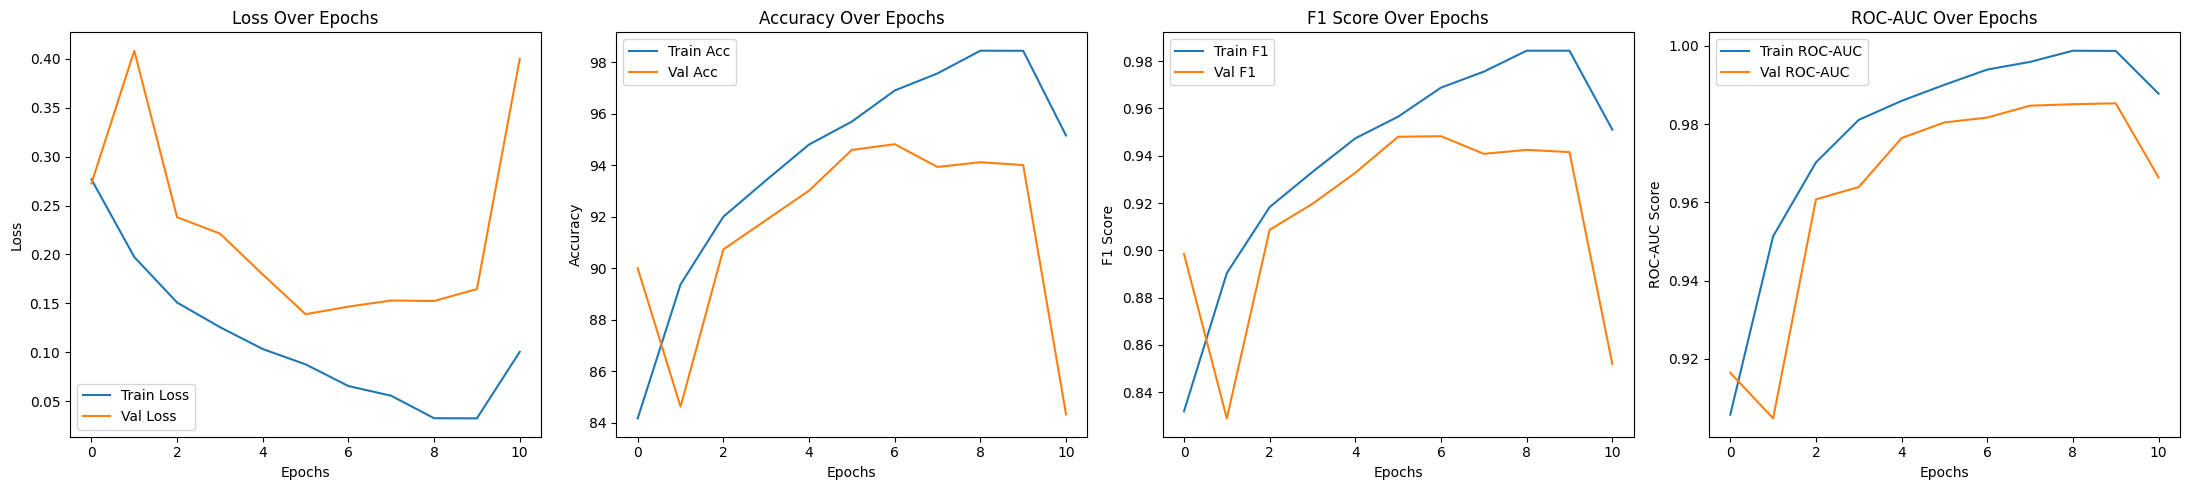

In [ ]:
def plot_graph(results: Dict[str, List[float]]):
    train_loss = results["train_loss"]
    val_loss = results["val_loss"]
    train_f1_score = results["train_f1_score"]
    val_f1_score = results["val_f1_score"]
    train_roc_auc = results["train_roc_auc"]
    val_roc_auc = results["val_roc_auc"]
    train_acc = results["train_acc"]
    val_acc = results["val_acc"]

    epochs = list(range(len(results["train_loss"])))

    fig, axs = plt.subplots(1, 4, figsize=(22, 5))

    # Loss 
    axs[0].plot(epochs, train_loss, label="Train Loss")
    axs[0].plot(epochs, val_loss, label="Val Loss")
    axs[0].set_title("Loss Over Epochs")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # Accuracy 
    axs[1].plot(epochs, train_acc, label="Train Acc")
    axs[1].plot(epochs, val_acc, label="Val Acc")
    axs[1].set_title("Accuracy Over Epochs")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    # F1 Score 
    axs[2].plot(epochs, train_f1_score, label="Train F1")
    axs[2].plot(epochs, val_f1_score, label="Val F1")
    axs[2].set_title("F1 Score Over Epochs")
    axs[2].set_xlabel("Epochs")
    axs[2].set_ylabel("F1 Score")
    axs[2].legend()

    # ROC-AUC 
    axs[3].plot(epochs, train_roc_auc, label="Train ROC-AUC")
    axs[3].plot(epochs, val_roc_auc, label="Val ROC-AUC")
    axs[3].set_title("ROC-AUC Over Epochs")
    axs[3].set_xlabel("Epochs")
    axs[3].set_ylabel("ROC-AUC Score")
    axs[3].legend()

    plt.tight_layout()
    plt.show()


plot_graph(model_results)